In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-gut-microbiome-with-asd/GSE113690_Autism_16S_rRNA_OTU_assignment_and_abundance.csv
/kaggle/input/human-gut-microbiome-with-asd/ASD meta abundance.csv


The dataset is from the research paper by Zhou Dan et al. published on April 21st of 2020 - [Altered gut microbial profile is associated with abnormal metabolism activity of Autism Spectrum Disorder](https://www.tandfonline.com/doi/full/10.1080/19490976.2020.1747329)

In [2]:
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay # to visualize prediction performance (ROC curve)
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
# from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, precision_score
from xgboost import XGBClassifier

# some hyper parameters
SEED = 123
test_train_split_SEED = 123
# FOLDS = 10
show_fold_stats = True
VERBOSE = 0
FOLDS = 5

min_max_scaler = preprocessing.MinMaxScaler()
quantile_transformer = preprocessing.QuantileTransformer(random_state=SEED)
MLP_param_grid = [
        {
            'activation' : ['identity', 'logistic', 'tanh', 'relu'],
            'solver' : ['lbfgs', 'sgd', 'adam'],
            'hidden_layer_sizes': [
             (5,),(10,),(15,),(20,),(25,),(30,),(40,),(50,),(100,)
             ]
        }
       ]

From the Abstract:<br>
> Autism Spectrum Disorder (ASD) is a severe neurodevelopmental disorder. To enhance the understanding of the gut microbiota structure in ASD children at different ages as well as the relationship between gut microbiota and fecal metabolites, we first used the 16S rRNA sequencing to evaluate the gut microbial population in a cohort of 143 children aged 2–13 years old. We found that the α-diversity of ASD group showed no significant change with age, while the TD group showed increased α-diversity with age, which indicates that the compositional development of the gut microbiota in ASD varies at different ages in ways that are not consistent with TD group. Recent studies have shown that chronic constipation is one of the most commonly obvious gastrointestinal (GI) symptoms along with ASD core symptoms. To further investigate the potential interaction effects between ASD and GI symptoms, the 30 C-ASD and their aged-matched TD were picked out to perform metagenomics analysis. We observed that C-ASD group displayed decreased diversity, depletion of species of Sutterella, Prevotella, and Bacteroides as well as dysregulation of associated metabolism activities, which may involve in the pathogenesis of C-ASD. Consistent with metagenomic analysis, liquid chromatography-mass spectrometry (LC/MS) revealed some of the differential metabolites between C-ASD and TD group were involved in the metabolic network of neurotransmitters including serotonin, dopamine, histidine, and GABA. Furthermore, we found these differences in metabolites were associated with altered abundance of specific bacteria. The study suggested possible future modalities for ASD intervention through targeting the specific bacteria associated with neurotransmitter metabolism.

In [3]:
pd_abundance = pd.read_csv('../data/data_2.csv')
pd_meta_abundance = pd.read_csv('../data/data_1.csv')

In [4]:
taxa = pd_abundance[['OTU', 'taxonomy']].set_index('OTU')
pd_abundance_T = pd_abundance.drop('taxonomy', axis=1).set_index('OTU').transpose()

target = pd_abundance_T.index.to_list()
binary_target = np.array([0 if t.startswith('A') else 1 for t in target ])

total_species = pd_abundance_T.sum(axis = 1)
abs_abundance = 31757
pd_rel_abundance = pd_abundance_T / abs_abundance 


In [5]:
print("first 5 rows:")
# Print the first 5 rows of the data
pd_rel_abundance.head()

first 5 rows:


OTU,OTU1,OTU2,OTU3,OTU4,OTU5,OTU6,OTU7,OTU8,OTU9,OTU10,...,OTU1329,OTU1330,OTU1331,OTU1332,OTU1333,OTU1334,OTU1335,OTU1336,OTU1337,OTU1338
A1,0.0,0.0,0.0,0.0,0.000000,0.000031,0.000000,0.000000,0.001574,0.000000,...,0.000031,0.000000,0.000031,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000315,0.000063,...,0.000157,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100,0.0,0.0,0.0,0.0,0.000031,0.000000,0.000000,0.015272,0.000409,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A101,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000031,0.004471,0.000535,0.000000,...,0.000000,0.000031,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A102,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000031,0.000283,0.000000,...,0.000031,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


First will try 16s rRNA using both RF and XGBoost

In [6]:
# Lets put aside a small test set, so we can check performance of different classifiers against it
disease_train, disease_test, disease_y_train, disease_y_test = train_test_split(pd_rel_abundance, binary_target, test_size = 0.2,  random_state = test_train_split_SEED , shuffle = True)   

In [7]:
print("first 5 rows:")
# Print the first 5 rows of the data
disease_train.head()


first 5 rows:


OTU,OTU1,OTU2,OTU3,OTU4,OTU5,OTU6,OTU7,OTU8,OTU9,OTU10,...,OTU1329,OTU1330,OTU1331,OTU1332,OTU1333,OTU1334,OTU1335,OTU1336,OTU1337,OTU1338
A12,0.0,0.0,0.000031,0.000000,0.0,0.0,0.000031,0.000031,0.000472,0.0,...,0.000063,0.000000,0.000031,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B108,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000094,0.000000,0.000315,0.0,...,0.000000,0.000031,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A18,0.0,0.0,0.000031,0.000000,0.0,0.0,0.000031,0.000157,0.000441,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A28,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000031,0.000063,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A49,0.0,0.0,0.000000,0.000063,0.0,0.0,0.000031,0.000063,0.000472,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
print("train data shape:")
disease_train.shape

train data shape:


(203, 1322)

In [9]:
print("test data shape:")
disease_test.shape

test data shape:


(51, 1322)

In [10]:
skf = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = SEED)

for fold, (idxT,idxV) in enumerate(skf.split(disease_train, disease_y_train)):

    X_train = disease_train.iloc[idxT]
    X_val = disease_train.iloc[idxV]
    y_train = disease_y_train[idxT]
    y_val = disease_y_train[idxV]

    # Random Forest
    clf = RandomForestClassifier(n_estimators = 500, random_state = SEED, verbose = 0)
    clf.fit(X_train, y_train )

    RF_pred_class = clf.predict(X_val)
    RF_preds = clf.predict_proba(X_val)
    
    RF_AUC_test_score = roc_auc_score(y_val, RF_preds[:,1])
    RF_f1_test = f1_score(y_val, RF_pred_class)
    RF_recall_test = recall_score(y_val, RF_pred_class)
    RF_precision_test = precision_score(y_val, RF_pred_class)
    
    if show_fold_stats:
        print('-' * 80)
        print('Fold : %s'%(fold+1))
        print('ROC AUC score for RandomForest model, validation set: %.4f'%RF_AUC_test_score)
        print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(RF_f1_test, RF_recall_test, RF_precision_test))
        print(confusion_matrix(y_val, RF_pred_class))
    
    # XGBoost
    XGB_model = XGBClassifier(n_estimators=5000, max_depth=None, 
                        learning_rate=0.005,
                        objective='binary:logistic', 
                        metric='auc',
                        verbosity  = VERBOSE,
                        # tree_method = 'gpu_hist',
                        use_label_encoder=False,
                        n_jobs=-1, random_state  = SEED )
    
    XGB_model.fit(X_train, y_train,
                    eval_set = [(X_val, y_val)],
                    eval_metric=['logloss'],
                    early_stopping_rounds = 100, verbose = VERBOSE )
        
    XGB_preds = XGB_model.predict_proba(X_val)
    XGB_class = XGB_model.predict(X_val)

    XGB_score = roc_auc_score(y_val, XGB_preds[:,1])
    XGB_f1 = f1_score(y_val, XGB_class)
    XGB_recall = recall_score(y_val, XGB_class)
    XGB_precision = precision_score(y_val, XGB_class)
    
    if show_fold_stats:        
        print('ROC AUC score for XGBoost model, validation set: %.4f'%XGB_score)
        print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(XGB_f1, XGB_recall, XGB_precision))
        print(confusion_matrix(y_val, XGB_class))
        
    # Logistic Regression
    LogReg_model = LogisticRegression(random_state=SEED)
    LogReg_model.fit(X_train, y_train)
    LogReg_preds = LogReg_model.predict_proba(X_val)
    LogReg_class = LogReg_model.predict(X_val)

    LogReg_score = roc_auc_score(y_val, LogReg_preds[:,1])
    LogReg_f1 = f1_score(y_val, LogReg_class)
    LogReg_recall = recall_score(y_val, LogReg_class)
    LogReg_precision = precision_score(y_val, LogReg_class)
    
    if show_fold_stats:        
        print('ROC AUC score for Logistic Regression model, validation set: %.4f'%LogReg_score)
        print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(LogReg_f1, LogReg_recall, LogReg_precision))
        print(confusion_matrix(y_val, LogReg_class))

    # Feedforward neural network (multilayer perceptron)
    
    # hyperparameter tuning (optional)
    # MLP_model = GridSearchCV(MLPClassifier(max_iter=1000,random_state=SEED), MLP_param_grid, cv=3,
    #                           scoring='accuracy')
  

    MLP_model = MLPClassifier(hidden_layer_sizes=(50,),max_iter=500,random_state=SEED)
    # you can set hyperparameters see: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
    # some parameter combinations will not converge as can be seen on the
    # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", category=ConvergenceWarning, module="sklearn"
        )
        MLP_model.fit(X_train, y_train)
        
    #     print("Best parameters set found on development set:")
    #     print(MLP_model.best_params_)
    MLP_preds = MLP_model.predict_proba(X_val)
    MLP_class = MLP_model.predict(X_val)

    MLP_score = roc_auc_score(y_val, MLP_preds[:,1])
    MLP_f1 = f1_score(y_val, MLP_class)
    MLP_recall = recall_score(y_val, MLP_class)
    MLP_precision = precision_score(y_val, MLP_class)
    
    if show_fold_stats:        
        print('ROC AUC score for MLP model, validation set: %.4f'%MLP_score)
        print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(MLP_f1, MLP_recall, MLP_precision))
        print(confusion_matrix(y_val, MLP_class))
        
        
#     RF_preds_test = clf.predict_proba(disease_test)
#     XGB_preds_test = XGB_model.predict_proba(disease_test)
#     LogReg_preds_test = LogReg_model.predict_proba(disease_test)
#     MLP_preds_test = MLP_model.predict_proba(disease_test)
#     avg_preds_test = (RF_preds_test[:,1] + XGB_preds_test[:,1] + LogReg_preds_test[:,1] + MLP_preds_test[:,1]) / 4

#     RF_test_AUC = roc_auc_score(disease_y_test, RF_preds_test[:,1])
#     print('ROC AUC score for RF for test set: %.4f'%RF_test_AUC)
#     XGB_test_AUC = roc_auc_score(disease_y_test, XGB_preds_test[:,1])
#     print('ROC AUC score for XGBoost model test set: %.4f'%XGB_test_AUC)
#     LogReg_test_AUC = roc_auc_score(disease_y_test, LogReg_preds_test[:,1])
#     print('ROC AUC score for Logistic Regression for test set: %.4f'%LogReg_test_AUC)
#     MLP_test_AUC = roc_auc_score(disease_y_test, MLP_preds_test[:,1])
#     print('ROC AUC score for MLP for test set: %.4f'%MLP_test_AUC)
#     average_AUC = roc_auc_score(disease_y_test, avg_preds_test )
#     print('ROC AUC score averaged between 2 models for test set: %.4f'%average_AUC)
    
#     avg_class = np.where(avg_preds_test < 0.7, 0, 1)
#     print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(f1_score(disease_y_test, avg_class), recall_score(disease_y_test, avg_class), precision_score(disease_y_test, avg_class)))
#     print(confusion_matrix(disease_y_test, avg_class))
    
    

--------------------------------------------------------------------------------
Fold : 1
ROC AUC score for RandomForest model, validation set: 0.9240
F1 : 0.8485, Recall : 0.8235 , Precision : 0.8750
[[22  2]
 [ 3 14]]
ROC AUC score for XGBoost model, validation set: 0.9387
F1 : 0.9091, Recall : 0.8824 , Precision : 0.9375
[[23  1]
 [ 2 15]]
ROC AUC score for Logistic Regression model, validation set: 0.7304
F1 : 0.0000, Recall : 0.0000 , Precision : 0.0000
[[24  0]
 [17  0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score for MLP model, validation set: 0.7941
F1 : 0.6471, Recall : 0.6471 , Precision : 0.6471
[[18  6]
 [ 6 11]]
--------------------------------------------------------------------------------
Fold : 2
ROC AUC score for RandomForest model, validation set: 0.9130
F1 : 0.8276, Recall : 0.7059 , Precision : 1.0000
[[24  0]
 [ 5 12]]
ROC AUC score for XGBoost model, validation set: 0.9534
F1 : 0.8485, Recall : 0.8235 , Precision : 0.8750
[[22  2]
 [ 3 14]]
ROC AUC score for Logistic Regression model, validation set: 0.7132
F1 : 0.0000, Recall : 0.0000 , Precision : 0.0000
[[24  0]
 [17  0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score for MLP model, validation set: 0.7917
F1 : 0.6061, Recall : 0.5882 , Precision : 0.6250
[[18  6]
 [ 7 10]]
--------------------------------------------------------------------------------
Fold : 3
ROC AUC score for RandomForest model, validation set: 0.9681
F1 : 0.8750, Recall : 0.8235 , Precision : 0.9333
[[23  1]
 [ 3 14]]
ROC AUC score for XGBoost model, validation set: 0.9730
F1 : 0.8824, Recall : 0.8824 , Precision : 0.8824
[[22  2]
 [ 2 15]]
ROC AUC score for Logistic Regression model, validation set: 0.5956
F1 : 0.0000, Recall : 0.0000 , Precision : 0.0000
[[24  0]
 [17  0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score for MLP model, validation set: 0.7328
F1 : 0.5625, Recall : 0.5294 , Precision : 0.6000
[[18  6]
 [ 8  9]]
--------------------------------------------------------------------------------
Fold : 4
ROC AUC score for RandomForest model, validation set: 0.9766
F1 : 0.9032, Recall : 0.8750 , Precision : 0.9333
[[23  1]
 [ 2 14]]
ROC AUC score for XGBoost model, validation set: 0.9505
F1 : 0.8667, Recall : 0.8125 , Precision : 0.9286
[[23  1]
 [ 3 13]]
ROC AUC score for Logistic Regression model, validation set: 0.7734
F1 : 0.0000, Recall : 0.0000 , Precision : 0.0000
[[24  0]
 [16  0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score for MLP model, validation set: 0.7604
F1 : 0.6250, Recall : 0.6250 , Precision : 0.6250
[[18  6]
 [ 6 10]]
--------------------------------------------------------------------------------
Fold : 5
ROC AUC score for RandomForest model, validation set: 0.9923
F1 : 0.9032, Recall : 0.8235 , Precision : 1.0000
[[23  0]
 [ 3 14]]
ROC AUC score for XGBoost model, validation set: 0.9744
F1 : 0.8276, Recall : 0.7059 , Precision : 1.0000
[[23  0]
 [ 5 12]]
ROC AUC score for Logistic Regression model, validation set: 0.8747
F1 : 0.0000, Recall : 0.0000 , Precision : 0.0000
[[23  0]
 [17  0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score for MLP model, validation set: 0.9130
F1 : 0.8125, Recall : 0.7647 , Precision : 0.8667
[[21  2]
 [ 4 13]]


--------------------------------------------------------------------------------
Fold : 5
ROC AUC score for RandomForest model, validation set: 1.0000
F1 : 1.0000, Recall : 1.0000 , Precision : 1.0000
[[119   0]
 [  0  84]]
ROC AUC score for Logistic Regression model, validation set: 0.7966
F1 : 0.0000, Recall : 0.0000 , Precision : 0.0000
[[119   0]
 [ 84   0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score for MLP model, validation set: 0.9383
F1 : 0.8193, Recall : 0.8095 , Precision : 0.8293
[[105  14]
 [ 16  68]]
ROC AUC score for XGBoost model, validation set: 1.0000
F1 : 1.0000, Recall : 1.0000 , Precision : 1.0000
[[119   0]
 [  0  84]]
ROC AUC score for RF for test set: 0.9938
ROC AUC score for XGBoost model test set: 0.9969
ROC AUC score for Logistic Regression for test set: 0.7114
ROC AUC score for MLP for test set: 0.7701
ROC AUC score averaged between 2 models for test set: 0.9938
F1 : 0.6829, Recall : 0.5185 , Precision : 1.0000
[[24  0]
 [13 14]]


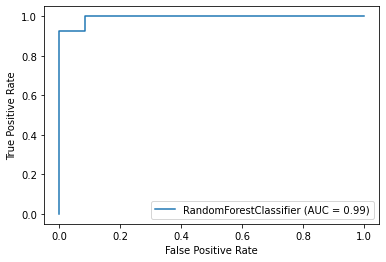

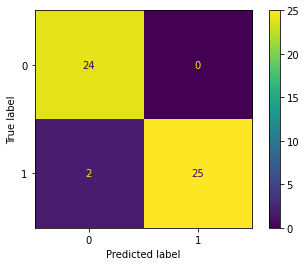

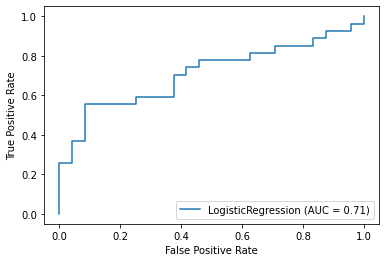

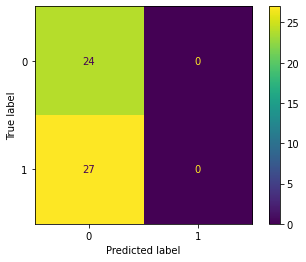

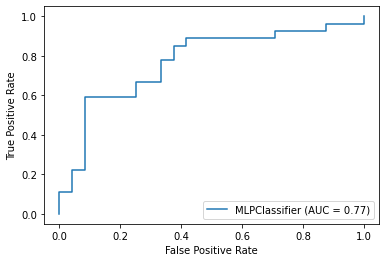

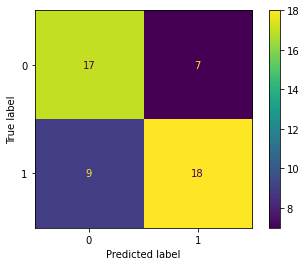

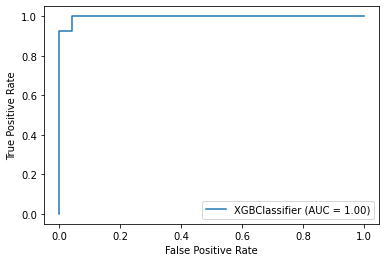

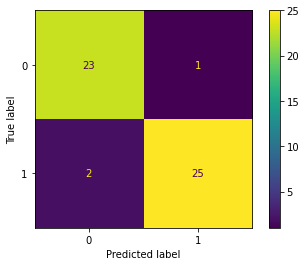

In [11]:
# Now we can train the learners (models) with the whole training dataset and evaluate the models on the test set
X_train = disease_train
X_val = disease_train
y_train = disease_y_train
y_val = disease_y_train
    
    
# Random Forest
clf = RandomForestClassifier(n_estimators = 500, random_state = SEED, verbose = 0)
clf.fit(X_train, y_train )

RF_pred_class = clf.predict(X_val)
RF_preds = clf.predict_proba(X_val)

RF_AUC_test_score = roc_auc_score(y_val, RF_preds[:,1])
RF_f1_test = f1_score(y_val, RF_pred_class)
RF_recall_test = recall_score(y_val, RF_pred_class)
RF_precision_test = precision_score(y_val, RF_pred_class)
    
if show_fold_stats:
    print('-' * 80)
    print('Fold : %s'%(fold+1))
    print('ROC AUC score for RandomForest model, validation set: %.4f'%RF_AUC_test_score)
    print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(RF_f1_test, RF_recall_test, RF_precision_test))
    print(confusion_matrix(y_val, RF_pred_class))
    
    
# Logistic Regression
LogReg_model = LogisticRegression(random_state=SEED)
LogReg_model.fit(X_train, y_train)
LogReg_preds = LogReg_model.predict_proba(X_val)
LogReg_class = LogReg_model.predict(X_val)

LogReg_score = roc_auc_score(y_val, LogReg_preds[:,1])
LogReg_f1 = f1_score(y_val, LogReg_class)
LogReg_recall = recall_score(y_val, LogReg_class)
LogReg_precision = precision_score(y_val, LogReg_class)
    
if show_fold_stats:        
    print('ROC AUC score for Logistic Regression model, validation set: %.4f'%LogReg_score)
    print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(LogReg_f1, LogReg_recall, LogReg_precision))
    print(confusion_matrix(y_val, LogReg_class))

# Feedforward neural network (multilayer perceptron)

# hyperparameter tuning (optional)
# MLP_model = GridSearchCV(MLPClassifier(max_iter=1000,random_state=SEED), MLP_param_grid, cv=3,
#                           scoring='accuracy')


MLP_model = MLPClassifier(hidden_layer_sizes=(50,),max_iter=500,random_state=SEED)
# you can set hyperparameters see: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
# some parameter combinations will not converge as can be seen on the
# plots so they are ignored here
with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore", category=ConvergenceWarning, module="sklearn"
    )
    MLP_model.fit(X_train, y_train)

#     print("Best parameters set found on development set:")
#     print(MLP_model.best_params_)
MLP_preds = MLP_model.predict_proba(X_val)
MLP_class = MLP_model.predict(X_val)

MLP_score = roc_auc_score(y_val, MLP_preds[:,1])
MLP_f1 = f1_score(y_val, MLP_class)
MLP_recall = recall_score(y_val, MLP_class)
MLP_precision = precision_score(y_val, MLP_class)

if show_fold_stats:        
    print('ROC AUC score for MLP model, validation set: %.4f'%MLP_score)
    print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(MLP_f1, MLP_recall, MLP_precision))
    print(confusion_matrix(y_val, MLP_class))

# XGBoost
XGB_model = XGBClassifier(n_estimators=5000, max_depth=None, 
                    learning_rate=0.005,
                    objective='binary:logistic', 
                    metric='auc',
                    verbosity  = VERBOSE,
                    # tree_method = 'gpu_hist',
                    use_label_encoder=False,
                    n_jobs=-1, random_state  = SEED )

XGB_model.fit(X_train, y_train,
                eval_set = [(X_val, y_val)],
                eval_metric=['logloss'],
                early_stopping_rounds = 100, verbose = VERBOSE )

XGB_preds = XGB_model.predict_proba(X_val)
XGB_class = XGB_model.predict(X_val)

XGB_score = roc_auc_score(y_val, XGB_preds[:,1])
XGB_f1 = f1_score(y_val, XGB_class)
XGB_recall = recall_score(y_val, XGB_class)
XGB_precision = precision_score(y_val, XGB_class)

if show_fold_stats:        
    print('ROC AUC score for XGBoost model, validation set: %.4f'%XGB_score)
    print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(XGB_f1, XGB_recall, XGB_precision))
    print(confusion_matrix(y_val, XGB_class))  

        
        
        
        
RF_preds_test = clf.predict_proba(disease_test)
XGB_preds_test = XGB_model.predict_proba(disease_test)
LogReg_preds_test = LogReg_model.predict_proba(disease_test)
MLP_preds_test = MLP_model.predict_proba(disease_test)
avg_preds_test = (RF_preds_test[:,1] + XGB_preds_test[:,1] + LogReg_preds_test[:,1] + MLP_preds_test[:,1]) / 4

RF_test_AUC = roc_auc_score(disease_y_test, RF_preds_test[:,1])
print('ROC AUC score for RF for test set: %.4f'%RF_test_AUC)
XGB_test_AUC = roc_auc_score(disease_y_test, XGB_preds_test[:,1])
print('ROC AUC score for XGBoost model test set: %.4f'%XGB_test_AUC)
LogReg_test_AUC = roc_auc_score(disease_y_test, LogReg_preds_test[:,1])
print('ROC AUC score for Logistic Regression for test set: %.4f'%LogReg_test_AUC)
MLP_test_AUC = roc_auc_score(disease_y_test, MLP_preds_test[:,1])
print('ROC AUC score for MLP for test set: %.4f'%MLP_test_AUC)
average_AUC = roc_auc_score(disease_y_test, avg_preds_test )
print('ROC AUC score averaged between 2 models for test set: %.4f'%average_AUC)
    
avg_class = np.where(avg_preds_test < 0.7, 0, 1)
print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(f1_score(disease_y_test, avg_class), recall_score(disease_y_test, avg_class), precision_score(disease_y_test, avg_class)))
print(confusion_matrix(disease_y_test, avg_class))
    
# ax = plt.gca()
RF_disp = metrics.plot_roc_curve(clf, disease_test, disease_y_test)
RF_CM = metrics.plot_confusion_matrix(clf, disease_test, disease_y_test)  
LogReg_disp = metrics.plot_roc_curve(LogReg_model, disease_test, disease_y_test)
LogReg_CM = metrics.plot_confusion_matrix(LogReg_model, disease_test, disease_y_test)
MLP_disp = metrics.plot_roc_curve(MLP_model, disease_test, disease_y_test)
MLP_CM = metrics.plot_confusion_matrix(MLP_model, disease_test, disease_y_test)
XGB_disp = metrics.plot_roc_curve(XGB_model, disease_test, disease_y_test)
XGB_CM = metrics.plot_confusion_matrix(XGB_model, disease_test, disease_y_test)

# RF_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax, alpha=0.8)
# LogReg_disp = RocCurveDisplay.from_estimator(LogReg_model, X_test, y_test, ax=ax, alpha=0.8)
# MLP_disp = RocCurveDisplay.from_estimator(MLP_model, X_test, y_test, ax=ax, alpha=0.8)
# XGB_disp = RocCurveDisplay.from_estimator(XGB_model, X_test, y_test, ax=ax, alpha=0.8)
# plt.plot(ax=ax, alpha=0.8)
plt.show()

Let's try the metagenomic data: 30 samples with ASD and 30 TD

In [12]:
# exclude absent spcecies
pd_meta_abundance = pd_meta_abundance[pd_meta_abundance.sum(axis = 1) !=0]

In [13]:
print("first 5 rows:")
# Print the first 5 rows of the data
pd_meta_abundance.head()

first 5 rows:


,Taxonomy,A3,A5,A6,A9,A31,A51,A52,A53,A54,...,B120,B127,B132,B141,B142,B143,B152,B156,B158,B164
0,g__Faecalibacterium;s__Faecalibacterium prausn...,4988,5060,2905,5745,4822,3889,4646,6337,5064,...,4471,5868,6561,4910,4492,2812,5303,4205,3430,4563
1,g__Hungatella;s__Hungatella hathewayi,5803,5612,4109,1432,2652,4175,3891,894,4903,...,2126,4429,2598,4222,4925,5753,1261,1822,2478,4868
2,g__Clostridium;s__uncultured Clostridium sp.,3793,2795,1355,5558,5383,3505,5541,4429,4121,...,4085,6041,6188,3960,4403,2841,2746,3808,3856,3211
3,g__Butyricimonas;s__Butyricimonas virosa,64,1385,725,1553,40,53,33,175,58,...,2065,21,27,55,35,8,884,13,3,218
4,g__Alistipes;s__Alistipes indistinctus,15,20,723,620,3261,43,83,37,43,...,90,22,30,1027,2641,4,1587,2223,6,1473


In [14]:
pd_meta_abndc = pd_meta_abundance.drop(['Taxonomy'], axis=1).T
target = pd_meta_abndc.index.to_list()
binary_target = np.array([0 if t.startswith('A') else 1 for t in target ])

In [15]:
print("first 5 rows:")
# Print the first 5 rows of the data
pd_meta_abndc.head()

first 5 rows:


,0,1,2,3,4,5,6,7,8,9,...,5447,5448,5449,5450,5451,5452,5453,5454,5455,5456
A3,4988,5803,3793,64,15,100,2119,12,453,1266,...,0,0,0,0,0,0,0,0,0,0
A5,5060,5612,2795,1385,20,29,1230,24,691,1682,...,0,0,0,0,0,0,0,0,0,0
A6,2905,4109,1355,725,723,11,1322,1,2278,43,...,0,0,0,0,0,0,0,0,0,0
A9,5745,1432,5558,1553,620,1320,2675,44,107,1726,...,0,0,0,0,0,0,0,0,1,0
A31,4822,2652,5383,40,3261,51,1470,26,342,1804,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Lets put aside a small test set, so we can check performance of different classifiers against it
disease_train, disease_test, disease_y_train, disease_y_test = train_test_split(pd_meta_abndc, binary_target, test_size = 0.2,  random_state = test_train_split_SEED , shuffle = True)   


In [17]:
print("train data shape:")
# Print the first 5 rows of the data
disease_train.shape

train data shape:


(48, 5457)

In [18]:
print("test data shape:")
# Print the first 5 rows of the data
disease_test.shape

test data shape:


(12, 5457)

In [19]:
print("first 5 rows:")
# Print the first 5 rows of the data
disease_train.head()

first 5 rows:


,0,1,2,3,4,5,6,7,8,9,...,5447,5448,5449,5450,5451,5452,5453,5454,5455,5456
B142,4492,4925,4403,35,2641,41,2027,9,1815,2277,...,0,0,0,0,0,0,0,0,0,0
A114,6762,1638,4336,1168,2821,3034,2036,74,747,2065,...,0,0,0,0,0,0,0,0,0,0
A68,4486,1266,2940,80,207,54,1420,7,105,1765,...,0,0,0,0,0,0,0,0,0,0
A3,4988,5803,3793,64,15,100,2119,12,453,1266,...,0,0,0,0,0,0,0,0,0,0
A51,3889,4175,3505,53,43,45,2262,9,1304,1441,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Visualization (optional)
# import seaborn as sns
# # KDE plots for each species
# sns.kdeplot(data=pd_meta_abndc, x='xx', hue='yy', shade=True) # TBF

# # Add title
# plt.title("Distribution of xx by yy") # TBF

In [21]:
# this subset of data is too small to have a separate test set, so we'd have to rely on CV only
skf = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = SEED)
# for fold, (idxT,idxV) in enumerate(skf.split(pd_meta_abndc, binary_target)):
for fold, (idxT,idxV) in enumerate(skf.split(disease_train, disease_y_train)):    
    # set training and validation indices
    X_train = disease_train.iloc[idxT]
    X_val = disease_train.iloc[idxV]
    y_train = disease_y_train[idxT]
    y_val = disease_y_train[idxV]
    
    
    # Random Forest
    clf = RandomForestClassifier(n_estimators = 500, random_state = SEED, verbose = 0)
    clf.fit(X_train, y_train )

    RF_pred_class = clf.predict(X_val)
    RF_preds = clf.predict_proba(X_val)
    
    RF_AUC_test_score = roc_auc_score(y_val, RF_preds[:,1])
    RF_f1_test = f1_score(y_val, RF_pred_class)
    RF_recall_test = recall_score(y_val, RF_pred_class)
    RF_precision_test = precision_score(y_val, RF_pred_class)
    
    if show_fold_stats:
        print('-' * 80)
        print('Fold : %s'%(fold+1))
        print('ROC AUC score for RandomForest model, validation set: %.4f'%RF_AUC_test_score)
        print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(RF_f1_test, RF_recall_test, RF_precision_test))
        print(confusion_matrix(y_val, RF_pred_class))
    
    
    # Logistic Regression
    LogReg_model = LogisticRegression(random_state=SEED)
    LogReg_model.fit(X_train, y_train)
    LogReg_preds = LogReg_model.predict_proba(X_val)
    LogReg_class = LogReg_model.predict(X_val)

    LogReg_score = roc_auc_score(y_val, LogReg_preds[:,1])
    LogReg_f1 = f1_score(y_val, LogReg_class)
    LogReg_recall = recall_score(y_val, LogReg_class)
    LogReg_precision = precision_score(y_val, LogReg_class)
    
    if show_fold_stats:        
        print('ROC AUC score for Logistic Regression model, validation set: %.4f'%LogReg_score)
        print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(LogReg_f1, LogReg_recall, LogReg_precision))
        print(confusion_matrix(y_val, LogReg_class))
    
    # Feedforward neural network (multilayer perceptron)
    
    # hyperparameter tuning (optional)
    # MLP_model = GridSearchCV(MLPClassifier(max_iter=1000,random_state=SEED), MLP_param_grid, cv=3,
    #                           scoring='accuracy')
  

    MLP_model = MLPClassifier(hidden_layer_sizes=(50,),max_iter=500,random_state=SEED)
    # you can set hyperparameters see: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
    # some parameter combinations will not converge as can be seen on the
    # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", category=ConvergenceWarning, module="sklearn"
        )
        MLP_model.fit(X_train, y_train)
        
    #     print("Best parameters set found on development set:")
    #     print(MLP_model.best_params_)
    MLP_preds = MLP_model.predict_proba(X_val)
    MLP_class = MLP_model.predict(X_val)

    MLP_score = roc_auc_score(y_val, MLP_preds[:,1])
    MLP_f1 = f1_score(y_val, MLP_class)
    MLP_recall = recall_score(y_val, MLP_class)
    MLP_precision = precision_score(y_val, MLP_class)
    
    if show_fold_stats:        
        print('ROC AUC score for MLP model, validation set: %.4f'%MLP_score)
        print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(MLP_f1, MLP_recall, MLP_precision))
        print(confusion_matrix(y_val, MLP_class))
        
    # XGBoost
    XGB_model = XGBClassifier(n_estimators=5000, max_depth=None, 
                        learning_rate=0.005,
                        objective='binary:logistic', 
                        metric='auc',
                        verbosity  = VERBOSE,
                        # tree_method = 'gpu_hist',
                        use_label_encoder=False,
                        n_jobs=-1, random_state  = SEED )
    
    XGB_model.fit(X_train, y_train,
                    eval_set = [(X_val, y_val)],
                    eval_metric=['logloss'],
                    early_stopping_rounds = 100, verbose = VERBOSE )
        
    XGB_preds = XGB_model.predict_proba(X_val)
    XGB_class = XGB_model.predict(X_val)

    XGB_score = roc_auc_score(y_val, XGB_preds[:,1])
    XGB_f1 = f1_score(y_val, XGB_class)
    XGB_recall = recall_score(y_val, XGB_class)
    XGB_precision = precision_score(y_val, XGB_class)

    if show_fold_stats:        
        print('ROC AUC score for XGBoost model, validation set: %.4f'%XGB_score)
        print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(XGB_f1, XGB_recall, XGB_precision))
        print(confusion_matrix(y_val, XGB_class))  
        



--------------------------------------------------------------------------------
Fold : 1
ROC AUC score for RandomForest model, validation set: 1.0000
F1 : 1.0000, Recall : 1.0000 , Precision : 1.0000
[[5 0]
 [0 5]]
ROC AUC score for Logistic Regression model, validation set: 0.9200
F1 : 0.9091, Recall : 1.0000 , Precision : 0.8333
[[4 1]
 [0 5]]
ROC AUC score for MLP model, validation set: 0.9000
F1 : 0.9091, Recall : 1.0000 , Precision : 0.8333
[[4 1]
 [0 5]]
ROC AUC score for XGBoost model, validation set: 0.9200
F1 : 0.7500, Recall : 0.6000 , Precision : 1.0000
[[5 0]
 [2 3]]
--------------------------------------------------------------------------------
Fold : 2
ROC AUC score for RandomForest model, validation set: 1.0000
F1 : 0.8889, Recall : 0.8000 , Precision : 1.0000
[[5 0]
 [1 4]]
ROC AUC score for Logistic Regression model, validation set: 0.5600
F1 : 0.4444, Recall : 0.4000 , Precision : 0.5000
[[3 2]
 [3 2]]
ROC AUC score for MLP model, validation set: 0.6000
F1 : 0.4444,

--------------------------------------------------------------------------------
Fold : 5
ROC AUC score for RandomForest model, validation set: 1.0000
F1 : 1.0000, Recall : 1.0000 , Precision : 1.0000
[[24  0]
 [ 0 24]]
ROC AUC score for Logistic Regression model, validation set: 1.0000
F1 : 1.0000, Recall : 1.0000 , Precision : 1.0000
[[24  0]
 [ 0 24]]
ROC AUC score for MLP model, validation set: 1.0000
F1 : 1.0000, Recall : 1.0000 , Precision : 1.0000
[[24  0]
 [ 0 24]]
ROC AUC score for XGBoost model, validation set: 1.0000
F1 : 1.0000, Recall : 1.0000 , Precision : 1.0000
[[24  0]
 [ 0 24]]
ROC AUC score for RF for test set: 0.9444
ROC AUC score for XGBoost model test set: 0.9167
ROC AUC score for Logistic Regression for test set: 0.9167
ROC AUC score for MLP for test set: 0.7778
ROC AUC score averaged between 2 models for test set: 0.9444
F1 : 0.8333, Recall : 0.8333 , Precision : 0.8333
[[5 1]
 [1 5]]


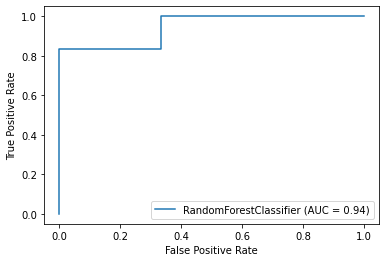

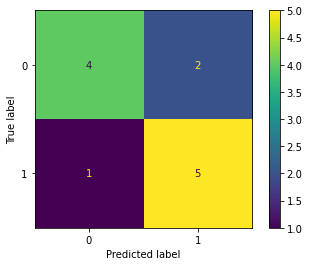

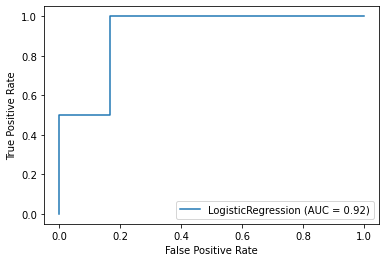

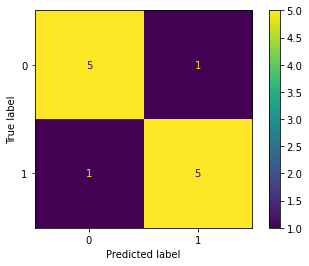

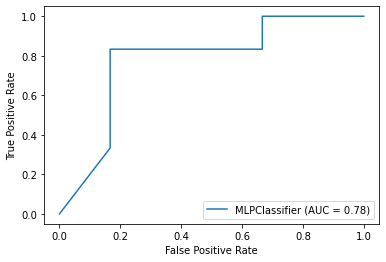

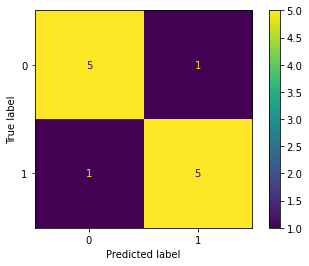

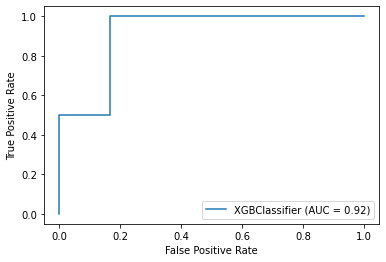

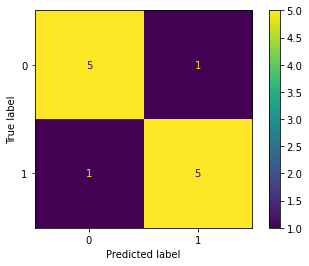

In [22]:
# Now we can train the learners (models) with the whole training dataset and evaluate the models on the test set
X_train = disease_train
X_val = disease_train
y_train = disease_y_train
y_val = disease_y_train
    
    
# Random Forest
clf = RandomForestClassifier(n_estimators = 500, random_state = SEED, verbose = 0)
clf.fit(X_train, y_train )

RF_pred_class = clf.predict(X_val)
RF_preds = clf.predict_proba(X_val)

RF_AUC_test_score = roc_auc_score(y_val, RF_preds[:,1])
RF_f1_test = f1_score(y_val, RF_pred_class)
RF_recall_test = recall_score(y_val, RF_pred_class)
RF_precision_test = precision_score(y_val, RF_pred_class)
    
if show_fold_stats:
    print('-' * 80)
    print('Fold : %s'%(fold+1))
    print('ROC AUC score for RandomForest model, validation set: %.4f'%RF_AUC_test_score)
    print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(RF_f1_test, RF_recall_test, RF_precision_test))
    print(confusion_matrix(y_val, RF_pred_class))
    
    
# Logistic Regression
LogReg_model = LogisticRegression(random_state=SEED)
LogReg_model.fit(X_train, y_train)
LogReg_preds = LogReg_model.predict_proba(X_val)
LogReg_class = LogReg_model.predict(X_val)

LogReg_score = roc_auc_score(y_val, LogReg_preds[:,1])
LogReg_f1 = f1_score(y_val, LogReg_class)
LogReg_recall = recall_score(y_val, LogReg_class)
LogReg_precision = precision_score(y_val, LogReg_class)
    
if show_fold_stats:        
    print('ROC AUC score for Logistic Regression model, validation set: %.4f'%LogReg_score)
    print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(LogReg_f1, LogReg_recall, LogReg_precision))
    print(confusion_matrix(y_val, LogReg_class))

# Feedforward neural network (multilayer perceptron)

# hyperparameter tuning (optional)
# MLP_model = GridSearchCV(MLPClassifier(max_iter=1000,random_state=SEED), MLP_param_grid, cv=3,
#                           scoring='accuracy')


MLP_model = MLPClassifier(hidden_layer_sizes=(50,),max_iter=500,random_state=SEED)
# you can set hyperparameters see: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
# some parameter combinations will not converge as can be seen on the
# plots so they are ignored here
with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore", category=ConvergenceWarning, module="sklearn"
    )
    MLP_model.fit(X_train, y_train)

#     print("Best parameters set found on development set:")
#     print(MLP_model.best_params_)
MLP_preds = MLP_model.predict_proba(X_val)
MLP_class = MLP_model.predict(X_val)

MLP_score = roc_auc_score(y_val, MLP_preds[:,1])
MLP_f1 = f1_score(y_val, MLP_class)
MLP_recall = recall_score(y_val, MLP_class)
MLP_precision = precision_score(y_val, MLP_class)

if show_fold_stats:        
    print('ROC AUC score for MLP model, validation set: %.4f'%MLP_score)
    print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(MLP_f1, MLP_recall, MLP_precision))
    print(confusion_matrix(y_val, MLP_class))

# XGBoost
XGB_model = XGBClassifier(n_estimators=5000, max_depth=None, 
                    learning_rate=0.005,
                    objective='binary:logistic', 
                    metric='auc',
                    verbosity  = VERBOSE,
                    # tree_method = 'gpu_hist',
                    use_label_encoder=False,
                    n_jobs=-1, random_state  = SEED )

XGB_model.fit(X_train, y_train,
                eval_set = [(X_val, y_val)],
                eval_metric=['logloss'],
                early_stopping_rounds = 100, verbose = VERBOSE )

XGB_preds = XGB_model.predict_proba(X_val)
XGB_class = XGB_model.predict(X_val)

XGB_score = roc_auc_score(y_val, XGB_preds[:,1])
XGB_f1 = f1_score(y_val, XGB_class)
XGB_recall = recall_score(y_val, XGB_class)
XGB_precision = precision_score(y_val, XGB_class)

if show_fold_stats:        
    print('ROC AUC score for XGBoost model, validation set: %.4f'%XGB_score)
    print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(XGB_f1, XGB_recall, XGB_precision))
    print(confusion_matrix(y_val, XGB_class))  

        
        
        
        
RF_preds_test = clf.predict_proba(disease_test)
XGB_preds_test = XGB_model.predict_proba(disease_test)
LogReg_preds_test = LogReg_model.predict_proba(disease_test)
MLP_preds_test = MLP_model.predict_proba(disease_test)
avg_preds_test = (RF_preds_test[:,1] + XGB_preds_test[:,1] + LogReg_preds_test[:,1] + MLP_preds_test[:,1]) / 4

RF_test_AUC = roc_auc_score(disease_y_test, RF_preds_test[:,1])
print('ROC AUC score for RF for test set: %.4f'%RF_test_AUC)
XGB_test_AUC = roc_auc_score(disease_y_test, XGB_preds_test[:,1])
print('ROC AUC score for XGBoost model test set: %.4f'%XGB_test_AUC)
LogReg_test_AUC = roc_auc_score(disease_y_test, LogReg_preds_test[:,1])
print('ROC AUC score for Logistic Regression for test set: %.4f'%LogReg_test_AUC)
MLP_test_AUC = roc_auc_score(disease_y_test, MLP_preds_test[:,1])
print('ROC AUC score for MLP for test set: %.4f'%MLP_test_AUC)
average_AUC = roc_auc_score(disease_y_test, avg_preds_test )
print('ROC AUC score averaged between 2 models for test set: %.4f'%average_AUC)
    
avg_class = np.where(avg_preds_test < 0.7, 0, 1)
print('F1 : %.4f, Recall : %.4f , Precision : %.4f'%(f1_score(disease_y_test, avg_class), recall_score(disease_y_test, avg_class), precision_score(disease_y_test, avg_class)))
print(confusion_matrix(disease_y_test, avg_class))
    
# ax = plt.gca()
RF_disp = metrics.plot_roc_curve(clf, disease_test, disease_y_test)
RF_CM = metrics.plot_confusion_matrix(clf, disease_test, disease_y_test)  
LogReg_disp = metrics.plot_roc_curve(LogReg_model, disease_test, disease_y_test)
LogReg_CM = metrics.plot_confusion_matrix(LogReg_model, disease_test, disease_y_test)
MLP_disp = metrics.plot_roc_curve(MLP_model, disease_test, disease_y_test)
MLP_CM = metrics.plot_confusion_matrix(MLP_model, disease_test, disease_y_test)
XGB_disp = metrics.plot_roc_curve(XGB_model, disease_test, disease_y_test)
XGB_CM = metrics.plot_confusion_matrix(XGB_model, disease_test, disease_y_test)

# RF_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax, alpha=0.8)
# LogReg_disp = RocCurveDisplay.from_estimator(LogReg_model, X_test, y_test, ax=ax, alpha=0.8)
# MLP_disp = RocCurveDisplay.from_estimator(MLP_model, X_test, y_test, ax=ax, alpha=0.8)
# XGB_disp = RocCurveDisplay.from_estimator(XGB_model, X_test, y_test, ax=ax, alpha=0.8)
# plt.plot(ax=ax, alpha=0.8)
plt.show()

Now you have learned how to develop some powerful machine learning models for tabular data. It's time to practice with tweaking the parameters and see how they change the performance.


<a href="https://imgflip.com/i/6hc2nv"><img src="https://i.imgflip.com/6hc2nv.jpg" title="made at imgflip.com"/></a><div><a href="https://imgflip.com/memegenerator">from Imgflip Meme Generator</a></div>